##**Analyse De Sentiments**

###Importation des Bibliothéques

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap


In [2]:
!pip install transformers

In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

##Préparation des données

In [4]:
from google.colab import files
data = files.upload()

Saving dataEquilibre.xlsx to dataEquilibre.xlsx


###Suppression des colonnes inutiles

In [ ]:
!pip install openpyxl --upgrade

In [6]:
import pandas as pd

file_path = "dataEquilibre.xlsx"
data = pd.read_excel(file_path)

#Dropping the columns having NaN values
data = data.dropna(axis=1)
data.head()
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  994 non-null    object
 1   label        994 non-null    object
dtypes: object(2)
memory usage: 15.7+ KB
None


### Suppression des doublons

In [8]:
from google.colab import files
import pandas as pd


data = pd.read_excel("dataEquilibre.xlsx")

# Supprimer les doublons
data["is_duplicate"] = data.duplicated()
print(f"Nombre total de doublons : {data['is_duplicate'].sum()}")
data = data.drop_duplicates(subset=["description"], keep="first")

# Enregistrer le fichier nettoyé
output_file = "cleaned_data.xlsx"
data.to_excel(output_file, index=False)

files.download(output_file)

print(f"Nombre de lignes restantes : {len(data)}")



Nombre total de doublons : 4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Nombre de lignes restantes : 990


###Nettoyage Du texte (descriptions)

In [9]:
import re

# mettre en minuscules et supprimer les espaces
def clean_text(text):
    text = text.lower().strip()
    return text


data["description_cleaned"] = data["description"].apply(clean_text)

print(data[["description", "description_cleaned"]].head())



                                         description  \
0  Les revenus de la SIAME ont enregistré à fin s...   
1  La société SIAME vient de remporter trois lots...   
2  Les revenus de la SIAME ont enregistré, au ter...   
3  Face aux défis croissants liés au stress hydri...   
4  C'est dans une ambiance festive et porteuse d'...   

                                 description_cleaned  
0  les revenus de la siame ont enregistré à fin s...  
1  la société siame vient de remporter trois lots...  
2  les revenus de la siame ont enregistré, au ter...  
3  face aux défis croissants liés au stress hydri...  
4  c'est dans une ambiance festive et porteuse d'...  


###**Exploratery data analysis**

In [10]:
description=data['description']
sentiment=data['label']

In [ ]:
print('Classes::\n',np.unique(sentiment))

Classes::
 ['negative' 'neutral' 'positive']


In [11]:
data['label'].value_counts()

,count
label,
negative,330
neutral,330
positive,330


<ipython-input-12-07641a8e4958>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="label", palette=custom_palette)


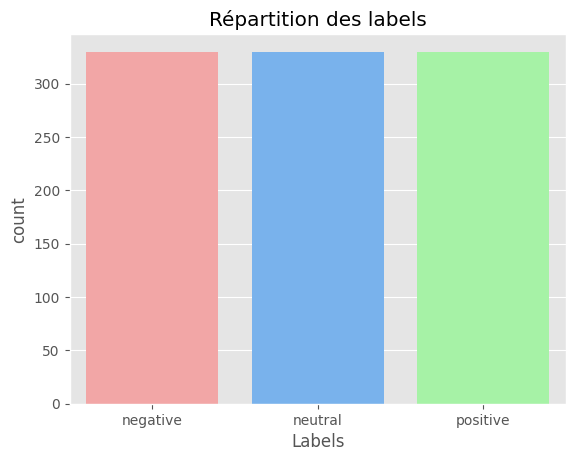

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

custom_palette = ["#FF9999", "#66B2FF", "#99FF99"]

plt.style.use("ggplot")
sns.countplot(data=data, x="label", palette=custom_palette)

plt.title("Répartition des labels")
plt.xlabel("Labels")
plt.ylabel("count")

plt.show()


<ipython-input-53-cd5fda01717c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="label", palette=custom_palette)


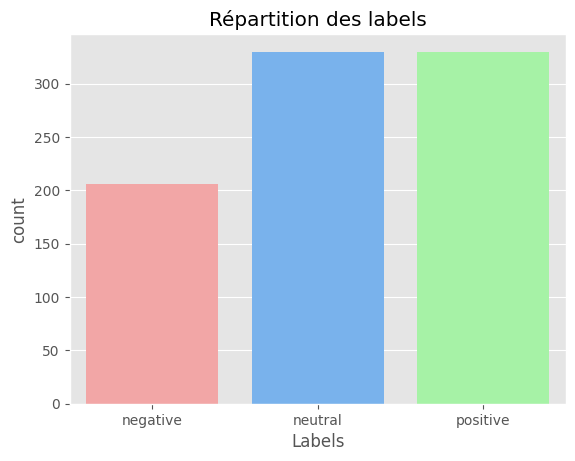

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


custom_palette = ["#FF9999", "#66B2FF", "#99FF99"]

plt.style.use("ggplot")
sns.countplot(data=data, x="label", palette=custom_palette)

plt.title("Répartition des labels")
plt.xlabel("Labels")
plt.ylabel("count")

plt.show()


#**BERT**

In [14]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

#modèle
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Fonction pour analyser le sentiment
def analyze_sentiment(text):

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)

    # Obtenir les scores de sentiment
    sentiment_scores = outputs.logits
    predicted_class = torch.argmax(sentiment_scores, dim=1).item()

    # Convertir les prédictions de classes originales (1-5) en catégories principales
    if predicted_class in [0, 1]:  # Classes 1-2 -> Negative
        return "negative"
    elif predicted_class == 2:    # Classe 3 -> Neutral
        return "neutral"
    else:                         # Classes 4-5 -> Positive
        return "positive"


data = pd.read_excel("cleaned_data.xlsx")

#mappage des chiffres vers les catégories texte.
label_mapping = {
    1: "negative",
    2: "negative",
    3: "neutral",
    4: "positive",
    5: "positive"
}

if data["label"].dtype != "object":
    data["label"] = data["label"].map(label_mapping)


data["predicted_label"] = data["description"].apply(analyze_sentiment)

print(data[["description", "label", "predicted_label"]])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

                                           description     label  \
0    Les revenus de la SIAME ont enregistré à fin s...  negative   
1    La société SIAME vient de remporter trois lots...   neutral   
2    Les revenus de la SIAME ont enregistré, au ter...  positive   
3    Face aux défis croissants liés au stress hydri...   neutral   
4    C'est dans une ambiance festive et porteuse d'...   neutral   
..                                                 ...       ...   
985  Le marché financier a connu une journée chargé...  negative   
986  Les pertes totales de l'année ont atteint 10 m...  negative   
987   L'ATB, un des principaux groupes bancaires tu...  negative   
988  La situation financière d'ATB continue à se dé...  negative   
989  La situation financière de WIFAK, l'un des pri...  negative   

    predicted_label  
0          negative  
1          negative  
2          negative  
3          positive  
4          positive  
..              ...  
985        negative  
986    

###BERT Evaluation

In [ ]:
#accuracy
accuracy = accuracy_score(data["label"], data["predicted_label"])
print(f"\nAccuracy: {accuracy}")

#rapport de classification
report = classification_report(
    data["label"],
    data["predicted_label"],
    target_names=["negative", "neutral", "positive"]
)
print("\n Rapport de classification pour BERT :\n")
print(report)


Accuracy: 0.38181818181818183

 Rapport de classification pour BERT :

              precision    recall  f1-score   support

    negative       0.47      0.98      0.64       330
     neutral       0.39      0.04      0.07       330
    positive       0.16      0.13      0.14       330

    accuracy                           0.38       990
   macro avg       0.34      0.38      0.28       990
weighted avg       0.34      0.38      0.28       990



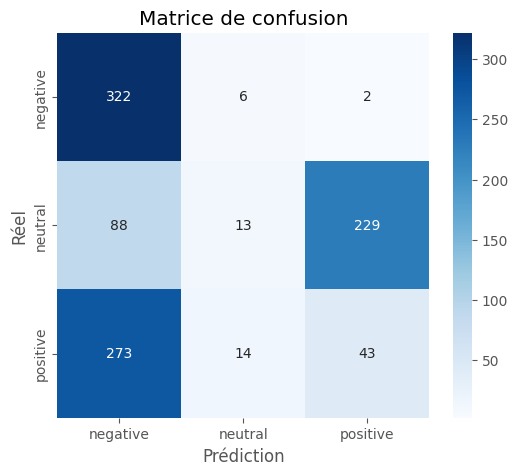

In [16]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(data["label"], data["predicted_label"], labels=["negative", "neutral", "positive"])

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()



#**FinBERT**

In [17]:
from transformers import pipeline, BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Load model and tokenizer
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

data = pd.read_excel("cleaned_data.xlsx")

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, truncation=True, max_length=512)

# Normalize labels
def normalize_label(label):
    return label.lower().strip()

data["predicted_label"] = data["description"].apply(
    lambda x: normalize_label(nlp(x[:512])[0]['label']) if len(tokenizer(x)['input_ids']) > 512 else normalize_label(nlp(x)[0]['label'])
)

# Display predictions
print(data[["description", "label", "predicted_label"]])


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                           description     label  \
0    Les revenus de la SIAME ont enregistré à fin s...  negative   
1    La société SIAME vient de remporter trois lots...   neutral   
2    Les revenus de la SIAME ont enregistré, au ter...  positive   
3    Face aux défis croissants liés au stress hydri...   neutral   
4    C'est dans une ambiance festive et porteuse d'...   neutral   
..                                                 ...       ...   
985  Le marché financier a connu une journée chargé...  negative   
986  Les pertes totales de l'année ont atteint 10 m...  negative   
987   L'ATB, un des principaux groupes bancaires tu...  negative   
988  La situation financière d'ATB continue à se dé...  negative   
989  La situation financière de WIFAK, l'un des pri...  negative   

    predicted_label  
0           neutral  
1           neutral  
2           neutral  
3           neutral  
4           neutral  
..              ...  
985         neutral  
986    

###FinBERT Evaluation

In [ ]:
# FinBERT Evaluation
print("Accuracy:", accuracy_score(data["label"], data["predicted_label"]))
print("\nRapport de classification pour FinBERT\n")
print(classification_report(data["label"], data["predicted_label"]))

Accuracy: 0.3333333333333333

Rapport de classification pour FinBERT

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       330
     neutral       0.33      1.00      0.50       330
    positive       0.00      0.00      0.00       330

    accuracy                           0.33       990
   macro avg       0.11      0.33      0.17       990
weighted avg       0.11      0.33      0.17       990



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


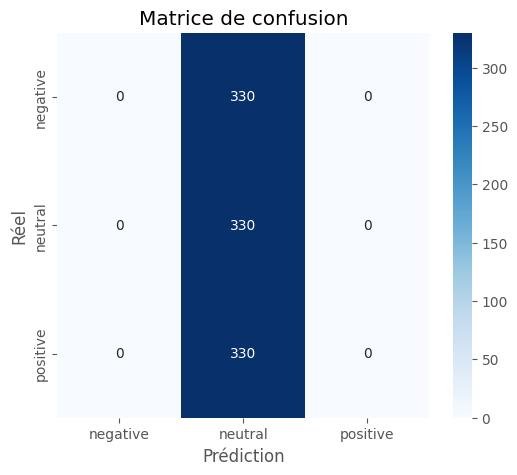

In [18]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(data["label"], data["predicted_label"], labels=["negative", "neutral", "positive"])

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()



#**DeBERTa**

In [19]:
from google.colab import files
from transformers import pipeline
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Upload the file
# data = files.upload()

data = pd.read_excel("cleaned_data.xlsx")

# Model
task = "text-classification"
model_id = "nickmuchi/deberta-v3-base-finetuned-finance-text-classification"
classifier = pipeline(task, model=model_id)

# Normalization
def normalize_label(label):
    return label.lower().strip()

# Map predicted labels to desired values
def map_label(label):
    label_mapping = {
        "bullish": "positive",
        "neutral": "neutral",
        "bearish": "negative"
    }
    return label_mapping.get(label, label)

# Apply prediction and mapping
data["predicted_label"] = data["description"].apply(
    lambda x: map_label(normalize_label(classifier(x)[0]['label']))
)

print(data[["description", "label", "predicted_label"]])


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Device set to use cuda:0


                                           description     label  \
0    Les revenus de la SIAME ont enregistré à fin s...  negative   
1    La société SIAME vient de remporter trois lots...   neutral   
2    Les revenus de la SIAME ont enregistré, au ter...  positive   
3    Face aux défis croissants liés au stress hydri...   neutral   
4    C'est dans une ambiance festive et porteuse d'...   neutral   
..                                                 ...       ...   
985  Le marché financier a connu une journée chargé...  negative   
986  Les pertes totales de l'année ont atteint 10 m...  negative   
987   L'ATB, un des principaux groupes bancaires tu...  negative   
988  La situation financière d'ATB continue à se dé...  negative   
989  La situation financière de WIFAK, l'un des pri...  negative   

    predicted_label  
0          negative  
1           neutral  
2          positive  
3           neutral  
4          positive  
..              ...  
985        negative  
986    

###DeBERTa Evaluation

In [ ]:
# Evaluation DeBERTa
print("Accuracy:", accuracy_score(data["label"], data["predicted_label"]))
print("\nRapport de classification pour DeBERTa:\n")
print(classification_report(data["label"], data["predicted_label"]))

Accuracy: 0.896969696969697

Rapport de classification pour DeBERTa:

              precision    recall  f1-score   support

    negative       0.98      0.93      0.96       330
     neutral       0.88      0.85      0.86       330
    positive       0.84      0.91      0.87       330

    accuracy                           0.90       990
   macro avg       0.90      0.90      0.90       990
weighted avg       0.90      0.90      0.90       990



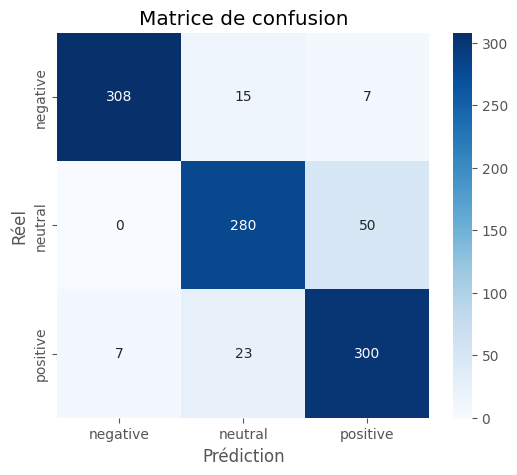

In [20]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(data["label"], data["predicted_label"], labels=["negative", "neutral", "positive"])

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()



#**RoBERTa**

In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Charger le modèle et le tokenizer
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/roberta-large-financial-news-sentiment-en")
model = AutoModelForSequenceClassification.from_pretrained("Jean-Baptiste/roberta-large-financial-news-sentiment-en")

# Initialiser le pipeline pour l'analyse de sentiments
sentiment_pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, truncation=True, max_length=512)

# Charger les données
data = pd.read_excel("cleaned_data.xlsx")

# Fonction pour normaliser les étiquettes du modèle
def normalize_label(label):
    return label.lower().strip()

# Appliquer le modèle
data["predicted_label"] = data["description"].apply(
    lambda x: normalize_label(sentiment_pipe(x)[0]["label"])
)

# Afficher les prédictions
print(data[["description", "label", "predicted_label"]])


tokenizer_config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/960 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Device set to use cuda:0


                                           description     label  \
0    Les revenus de la SIAME ont enregistré à fin s...  negative   
1    La société SIAME vient de remporter trois lots...   neutral   
2    Les revenus de la SIAME ont enregistré, au ter...  positive   
3    Face aux défis croissants liés au stress hydri...   neutral   
4    C'est dans une ambiance festive et porteuse d'...   neutral   
..                                                 ...       ...   
985  Le marché financier a connu une journée chargé...  negative   
986  Les pertes totales de l'année ont atteint 10 m...  negative   
987   L'ATB, un des principaux groupes bancaires tu...  negative   
988  La situation financière d'ATB continue à se dé...  negative   
989  La situation financière de WIFAK, l'un des pri...  negative   

    predicted_label  
0          negative  
1           neutral  
2           neutral  
3           neutral  
4           neutral  
..              ...  
985         neutral  
986    

###RoBERTa Evaluation

In [23]:
# Évaluer les performances du modèle RoBERTa
print("Accuracy:", accuracy_score(data["label"], data["predicted_label"]))
print("\nRapport de classification pour RoBERTa:\n")
print(classification_report(data["label"], data["predicted_label"]))

Accuracy: 0.6727272727272727

Rapport de classification pour RoBERTa:

              precision    recall  f1-score   support

    negative       0.89      0.38      0.53       330
     neutral       0.59      0.95      0.73       330
    positive       0.71      0.70      0.70       330

    accuracy                           0.67       990
   macro avg       0.73      0.67      0.65       990
weighted avg       0.73      0.67      0.65       990



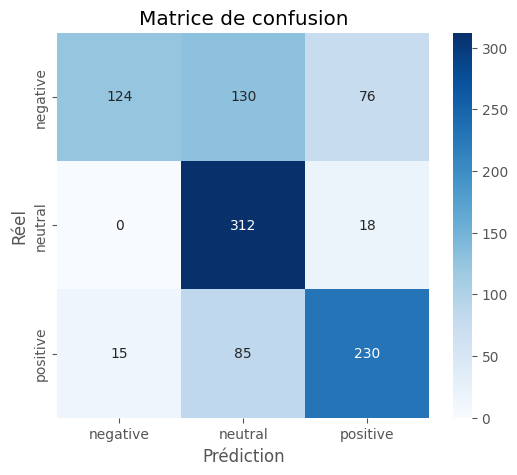

In [22]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(data["label"], data["predicted_label"], labels=["negative", "neutral", "positive"])

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()



#**FinVADER**

In [25]:
#!pip install finvader


In [26]:
import subprocess
subprocess.run(["pip", "install", "finvader"])


CompletedProcess(args=['pip', 'install', 'finvader'], returncode=0)

In [27]:
import pandas as pd
from finvader import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, accuracy_score

# Charger les données
data = pd.read_excel("cleaned_data.xlsx")

# Initialiser l'analyseur FinVader
analyzer = SentimentIntensityAnalyzer()



# Fonction pour obtenir les sentiments
def get_finvader_label(text):
    sentiment_scores = analyzer.polarity_scores(text)
    # FinVader donne un score de sentiment : on le convertit en labels
    if sentiment_scores['compound'] >= 0.05:
        return "positive"
    elif sentiment_scores['compound'] <= -0.05:
        return "negative"
    else:
        return "neutral"

# Appliquer FinVader sur les descriptions
data["predicted_label"] = data["description"].apply(get_finvader_label)


print(data[["description", "label", "predicted_label"]])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                                           description     label  \
0    Les revenus de la SIAME ont enregistré à fin s...  negative   
1    La société SIAME vient de remporter trois lots...   neutral   
2    Les revenus de la SIAME ont enregistré, au ter...  positive   
3    Face aux défis croissants liés au stress hydri...   neutral   
4    C'est dans une ambiance festive et porteuse d'...   neutral   
..                                                 ...       ...   
985  Le marché financier a connu une journée chargé...  negative   
986  Les pertes totales de l'année ont atteint 10 m...  negative   
987   L'ATB, un des principaux groupes bancaires tu...  negative   
988  La situation financière d'ATB continue à se dé...  negative   
989  La situation financière de WIFAK, l'un des pri...  negative   

    predicted_label  
0           neutral  
1          negative  
2           neutral  
3          positive  
4          positive  
..              ...  
985         neutral  
986    

###FinVADER Evaluation

In [ ]:
#Évaluation des performances de FinVader

print("\nAccuracy:", accuracy_score(data["label"], data["predicted_label"]))
print("\nRapport de classification pour FinVADER\n")
print(classification_report(data["label"], data["predicted_label"]))



Accuracy: 0.22121212121212122

Rapport de classification pour FinVADER

              precision    recall  f1-score   support

    negative       0.38      0.27      0.31       330
     neutral       0.19      0.29      0.23       330
    positive       0.14      0.11      0.12       330

    accuracy                           0.22       990
   macro avg       0.24      0.22      0.22       990
weighted avg       0.24      0.22      0.22       990



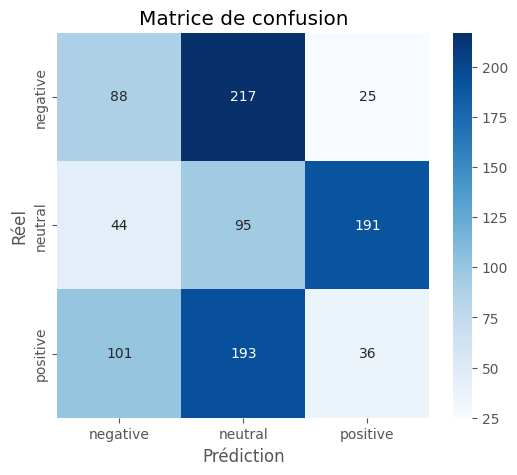

In [28]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(data["label"], data["predicted_label"], labels=["negative", "neutral", "positive"])

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()



#**Comparaison entre les modèles**

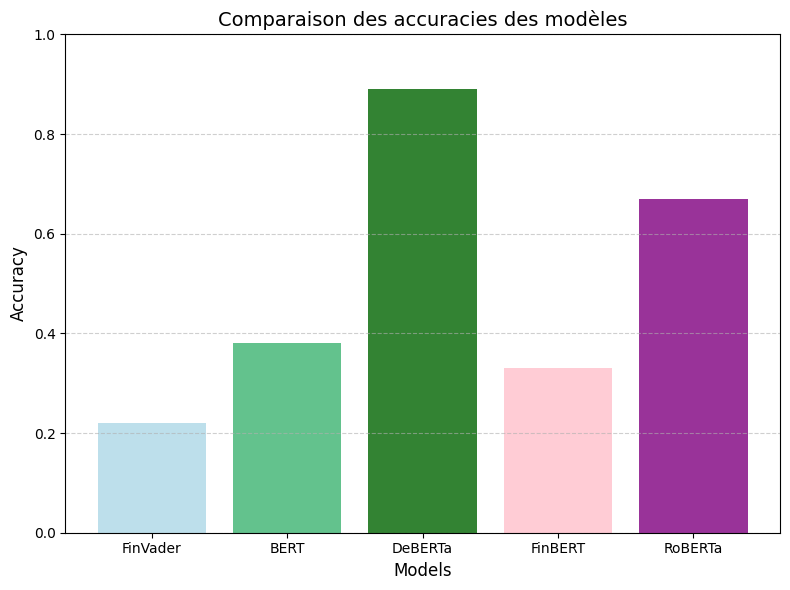

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


models = ['FinVader', 'BERT', 'DeBERTa', 'FinBERT', 'RoBERTa']
accuracies = [0.22, 0.38, 0.89, 0.33, 0.67]

# Création des graphiques
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# Diagramme à barres pour les accuracies
axes.bar(models, accuracies, color=['lightblue', 'mediumseagreen', 'darkgreen', 'pink', 'purple'], alpha=0.8)
axes.set_title("Comparaison des accuracies des modèles", fontsize=14)
axes.set_ylabel("Accuracy", fontsize=12)
axes.set_ylim(0, 1)
axes.set_xlabel("Models", fontsize=12)
axes.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()

# Affichage
plt.show()


#**Analyse** **Qualitative**

In [ ]:
import pandas as pd
from finvader import SentimentIntensityAnalyzer
from transformers import pipeline, BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score

# Load the data
data = pd.read_excel("cleaned_data.xlsx")

# Apply FinVader on the descriptions
data["finvader_label"] = data["description"].apply(get_finvader_label)


# Apply FinBERT model
data["finbert_label"] = data["description"].apply(
    lambda x: normalize_label(nlp(x[:512])[0]['label']) if len(tokenizer(x)['input_ids']) > 512 else normalize_label(nlp(x)[0]['label'])
)


# Apply DeBERTa model
data["deberta_label"] = data["description"].apply(
    lambda x: map_label(normalize_label(classifier(x)[0]['label']))
)

# Apply BERT model
#data["BERT_predicted_label"] = data["description"].apply(analyze_sentiment)

#apply RoBERTa
data["RoBERTa_label"] = data["description"].apply(
    lambda x: normalize_label(sentiment_pipe(x)[0]["label"])
)


# Select the top 5 descriptions for analysis
top_n = 5
data_subset = data.head(top_n)

# Display the results
print(data_subset[["description", "label","finvader_label", "finbert_label", "deberta_label","RoBERTa_label"]])



Token indices sequence length is longer than the specified maximum sequence length for this model (850 > 512). Running this sequence through the model will result in indexing errors


                                         description     label finvader_label  \
0  Les revenus de la SIAME ont enregistré à fin s...  negative        neutral   
1  La société SIAME vient de remporter trois lots...   neutral       negative   
2  Les revenus de la SIAME ont enregistré, au ter...  positive        neutral   
3  Face aux défis croissants liés au stress hydri...   neutral       positive   
4  C'est dans une ambiance festive et porteuse d'...   neutral       positive   

  finbert_label deberta_label RoBERTa_label  
0       neutral      negative      negative  
1       neutral       neutral       neutral  
2       neutral      positive       neutral  
3       neutral       neutral       neutral  
4       neutral      positive       neutral  


In [ ]:
import pandas as pd
from finvader import SentimentIntensityAnalyzer
from transformers import pipeline, BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score


data = pd.read_excel("cleaned_data.xlsx")

#FinVader model
analyzer = SentimentIntensityAnalyzer()

def get_finvader_label(text):
    sentiment_scores = analyzer.polarity_scores(text)
    if sentiment_scores['compound'] >= 0.05:
        return "positive"
    elif sentiment_scores['compound'] <= -0.05:
        return "negative"
    else:
        return "neutral"

# Apply FinVader on the descriptions
data["finvader_label"] = data["description"].apply(get_finvader_label)

#FinBERT model
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Sentiment-analysis pipeline
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, truncation=True, max_length=512)

# Function to normalize FinBERT labels
def normalize_label(label):
    return label.lower().strip()

# Apply FinBERT model
data["finbert_label"] = data["description"].apply(
    lambda x: normalize_label(nlp(x[:512])[0]['label']) if len(tokenizer(x)['input_ids']) > 512 else normalize_label(nlp(x)[0]['label'])
)

# DeBERTa model
task = "text-classification"
model_id = "nickmuchi/deberta-v3-base-finetuned-finance-text-classification"
classifier = pipeline(task, model=model_id)


# Apply DeBERTa model
data["deberta_label"] = data["description"].apply(
    lambda x: map_label(normalize_label(classifier(x)[0]['label']))
)

# Select the top 5 descriptions for analysis
top_n = 5
data_subset = data.head(top_n)

# Display the results
print(data_subset[["description", "label","finvader_label", "finbert_label", "deberta_label"]])



Device set to use cpu
Device set to use cpu


                                         description     label finvader_label  \
0  Les revenus de la SIAME ont enregistré à fin s...  negative        neutral   
1  La société SIAME vient de remporter trois lots...   neutral       negative   
2  Les revenus de la SIAME ont enregistré, au ter...  positive        neutral   
3  Face aux défis croissants liés au stress hydri...   neutral       positive   
4  C'est dans une ambiance festive et porteuse d'...   neutral       positive   

  finbert_label deberta_label  
0       neutral      negative  
1       neutral       neutral  
2       neutral      positive  
3       neutral       neutral  
4       neutral      positive  
